# Estimate coordinates of nodes with adjacency matrix by GCNN

## Import packages

In [2]:
import datetime
import math
import os
import os.path as osp
import random
import time

import igraph
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from joblib import Parallel, delayed
import matplotlib as mpl
from matplotlib import pyplot as plt
from natsort import natsorted
from scipy.io import mmread
from torch_geometric.data import Data, DataLoader, Batch, Dataset, InMemoryDataset
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import Compose
from torch_scatter import scatter

# random seed
torch.manual_seed(1234)

np.random.seed(1234)
random.seed(1234)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


## Set variables

In [4]:
is_trial = True
is_weighted = True
exists_noise = False
K, L0 = 1.0, 1.0
EPS = 1e-6

n_jobs = int(os.cpu_count() * 0.5)

data_size_type = "small_" if is_trial else "large_"
Dataset_type = "Dataset"
root = osp.join(
    "data",
    data_size_type + "reconstruction_" + Dataset_type
)

if is_trial:
    epoch_num = 5
    batch_size = 30
else:
    epoch_num = 100
    batch_size = 8

print("n_jobs = {}".format(n_jobs))

n_jobs = 4


## Define dataset

In [6]:
class MyDataset(Dataset):

    processed_file_name = "data_{}.pt"

    def __init__(self, root, transform=None, pre_transform=None):
        super(MyDataset, self).__init__(root, transform, pre_transform)

    @property
    def processed_file_names(self):
        num_graph = len(os.listdir(osp.join(self.raw_dir, "adjs")))
        return [self.processed_file_name.format(i) for i in range(num_graph)]

    def process(self):
        adj_file_names = natsorted(os.listdir(osp.join(self.raw_dir, "adjs")))
        coords_file_names = natsorted(os.listdir(osp.join(self.raw_dir, "coords")))
        num_samples = len(adj_file_names)

        ######################
        # self cannot use in closure with joblib?
        raw_dir = self.raw_dir
        processed_dir = self.processed_dir
        processed_file_name = self.processed_file_name
        pre_transform = self.pre_transform
        #######################
        #def generate_weighted_unweighted_Data(index):
        def generate_weighted_unweighted_Data(index, raw_dir, procesed_dir, processed_file_name, pre_transform):
            adj_file_name = adj_file_names[index]
            coords_file_name = coords_file_names[index]
            #adj_coo = mmread(osp.join(self.raw_dir, "adjs", adj_file_name))
            #coords_nda = mmread(osp.join(self.raw_dir, "coords", coords_file_name))
            adj_coo = mmread(osp.join(raw_dir, "adjs", adj_file_name))
            coords_nda = mmread(osp.join(raw_dir, "coords", coords_file_name))
            num_nodes = adj_coo.shape[0]
            edge_index, edge_attr = torch_geometric.utils.from_scipy_sparse_matrix(adj_coo)

            # compute graph_dist_matrix
            edges = np.array([adj_coo.row, adj_coo.col]).T
            g = igraph.Graph(n=num_nodes,edges=edges)
            #g.es["weight"] = adj_coo.data
            g.es["weight"] = adj_coo.data ** -1
            weighted_dist = torch.tensor(g.shortest_paths_dijkstra(weights="weight"), dtype=torch.float)
            unweighted_dist = torch.tensor(g.shortest_paths_dijkstra(), dtype=torch.float)

            data = Data(
                x=torch.ones((num_nodes, 1)).float(),
                edge_index=edge_index,
                #edge_attr=edge_attr.view(-1, 1).float(),
                edge_attr=edge_attr.view(-1, 1).float() ** -1,
                pos=torch.tensor(coords_nda).float(),
                weighted_dist=weighted_dist.view(-1, 1),
                unweighted_dist=unweighted_dist.view(-1, 1),
            )

            #if self.pre_transform is not None:
            #    data = self.pre_transform(data)
            if pre_transform is not None:
                data = pre_transform(data)

            torch.save(
                data,
                osp.join(processed_dir, processed_file_name.format(index)),
            )

        Parallel(n_jobs=n_jobs)(
            #[delayed(generate_weighted_unweighted_Data)(i) for i in range(num_samples)]
            [delayed(generate_weighted_unweighted_Data)(i,
                                                        raw_dir,
                                                        processed_dir,
                                                        processed_file_name,
                                                        pre_transform
                                                       ) for i in range(num_samples)]
        )

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, "data_{}.pt".format(idx)))
        return data


class WeightedOrUnweighted:
    r"""Transform a Data object based on whether it is used as weighted or unweighted"""
    def __init__(self, is_weighted):
        self.is_weighted = is_weighted

    def __call__(self, data):
        if self.is_weighted:
            data.dist = data.weighted_dist
        else:
            data.edge_attr = None
            data.dist = data.unweighted_dist

        del data.weighted_dist, data.unweighted_dist
        return data

## Network and Loss function

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 48)
        self.conv4 = GCNConv(48, 64)
        self.conv5 = GCNConv(64, 96)
        self.conv6 = GCNConv(96, 128)
        self.linear1 = torch.nn.Linear(128, 64)
        self.linear2 = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Network does not work if a tensor whoes shape is (n, 1) is used as edge_weight. 
        # Network works is the shape of the tensor is (n, ), which might be a bug of PyG?
        edge_weight = None if data.edge_attr is None else torch.squeeze(data.edge_attr)
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv5(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv6(x, edge_index, edge_weight)
        x = F.relu(x)

        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


class KKLoss(nn.Module):
    """Return energy of Kamada-Kawai as loss"""

    def __init__(self, K=1.0, L0=1.0, eps=1e-6):
        super().__init__()
        self.K = K
        self.L0 = L0
        self.eps = eps

    def forward(self, batch, prediction):
        """
        The Kamada-Kawai loss of the graph included in
        the batch is calculated in parallel as in the mini-batch.
        """
        data_list = batch.to_data_list()
        s = torch.tensor(0, dtype=torch.float).to(device)
        num_graphs = 0
        for h, data in enumerate(data_list):

            if data.num_edges == 0:  # skip graph which has no edge
                continue

            num_graphs += 1
            graph_dist = data.dist.view(data.num_nodes, data.num_nodes)

            if float("inf") in graph_dist:
                d_max = torch.unique(graph_dist, sorted=True)[-2]  # avoid inf
            else:
                d_max = torch.unique(graph_dist, sorted=True)[-1]

            L = self.L0 / d_max
            positions = prediction[torch.flatten(batch.batch == h), :]

            for i in range(data.num_nodes - 1):
                for j in range(i + 1, data.num_nodes):
                    if graph_dist[i,j] == float("inf"):
                        continue
                    else:
                        k = K / (graph_dist[i, j] ** 2)
                        l = L * graph_dist[i, j]

                        dx = positions[i, 0] - positions[j, 0]
                        dy = positions[i, 1] - positions[j, 1]
                        s += 0.5 * k * (dx**2 + dy**2 + l**2 - 2 * l * torch.sqrt(dx**2 + dy**2 + self.eps))

        return s / num_graphs

## Generate DataLoader

In [10]:
weighted_or_unweithted = WeightedOrUnweighted(is_weighted=is_weighted)
my_transform = weighted_or_unweithted

train_root = osp.join(root, "train")
val_root = osp.join(root, "val")
test_root = osp.join(root, "test")

train_set = MyDataset(train_root, transform=my_transform)
val_set = MyDataset(val_root, transform=my_transform)
#test_set = MyDataset(test_root, transform=my_transform)
test_set = MyDataset(test_root)

train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

train_size = len(train_set)
val_size = len(val_set)
test_size = len(test_set)

## Learning

In [13]:
start = time.time()
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
#criterion = KKLoss(K=K, L0=L0, eps=EPS)
history = {
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(epoch_num):
    train_loss = 0.0
    model.train()
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        prediction = model(batch)
        #loss = criterion(batch, prediction)  # for KK loss
        loss = criterion(prediction, batch.pos)  # for MSE loss
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        if i % 10 == 9:
            progress_bar = (
                "["
                + ("=" * ((i + 1) // 10))
                + (" " * ((train_size // 100 - (i + 1)) // 10))
                + "]"
            )
            print(
                "\repoch: {:d} loss: {:.3f}  {}".format(
                    epoch + 1, loss.cpu().item(), progress_bar,
                ),
                end="  ",
            )

    print(
        "\repoch: {:d} loss: {:.3f}".format(
            epoch + 1, train_loss / math.ceil(train_size / batch_size)
        ),
        end="  ",
    )
    history["train_loss"].append(train_loss / math.ceil(train_size / batch_size))

    batch_num = 0
    loss = 0
    with torch.no_grad():
        model.eval()
        for batch in val_loader:
            batch = batch.to(device)
            prediction = model(batch)
            #loss += criterion(batch, prediction)  # for KK
            loss += criterion(prediction, batch.pos)  # for MSE
            batch_num += 1

    history["val_loss"].append(loss.cpu().item() / batch_num)
    endstr = " " * max(1, (train_size // 1000 - 39)) + "\n"
    print(f"Val Loss: {loss.cpu().item()/batch_num:.3f}", end=endstr)

print("Finished Training")
elapsed_time = time.time() - start
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))

epoch: 1 loss: 0.613  Val Loss: 0.640 
epoch: 2 loss: 0.607  Val Loss: 0.641 
epoch: 3 loss: 0.603  Val Loss: 0.645 
epoch: 4 loss: 0.601  Val Loss: 0.649 
epoch: 5 loss: 0.600  Val Loss: 0.653 
Finished Training
elapsed time: 0:00:00


## Visualization

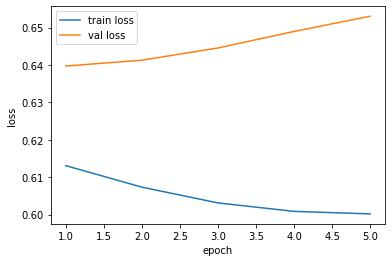

In [14]:
# Loss
plt.xlabel("epoch")
plt.ylabel("loss")

x = np.arange(epoch_num) + 1
plt.plot(x, history["train_loss"], label="train loss")
plt.plot(x, history["val_loss"], label="val loss")
plt.legend()
plt.show()

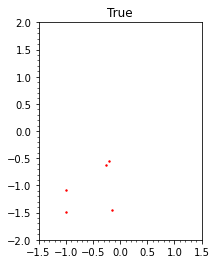

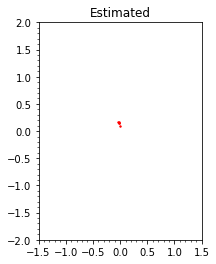

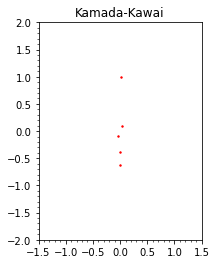

In [15]:
# Plot nodes
test_index = 0
nBeads = test_set[test_index].num_nodes
node_list = list(range(nBeads))
test_data = test_set[test_index].to(device)

# Estimate coordinates of nodes of test data
with torch.no_grad():
    model.eval()
    estimated_coords = model(test_data)

true_coords = test_data.pos.to("cpu").detach().numpy().copy()

G = torch_geometric.utils.to_networkx(
    test_data,
    node_attrs=["pos"],
    edge_attrs=["edge_attr"],
    to_undirected=True)

true_pos = dict(zip(node_list, true_coords))
estimated_pos = dict(zip(node_list, estimated_coords.cpu().detach().numpy()))
KK_pos = nx.kamada_kawai_layout(G,pos=nx.random_layout(G, dim=2, seed=1), weight="edge_attr", dim=2)

titles = ["True", "Estimated", "Kamada-Kawai"]
positions = [true_pos, estimated_pos, KK_pos]
for i, (t,p) in enumerate(zip(titles, positions)):
    fig = plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.set_title(t)
    ax.set_xlim(left=-1.5, right=1.5)
    ax.set_ylim(bottom=-2, top=2)
    nx.draw_networkx_nodes(G, pos=p,ax=ax, node_color="red", node_size=2)
    ax.tick_params(which="both", left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_aspect(aspect="equal")
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    plt.show()


In [20]:
print("Compare euclidean distance to graph distance")
dx = test_data.pos[:, [0]] - test_data.pos[:, 0]
dy = test_data.pos[:, [1]] - test_data.pos[:, 1]
euclidean_dist = torch.sqrt(dx ** 2 + dy ** 2)

print("(i,j): (euclidean_dist, weighted_dist, unweghted_dist)")
indices = np.random.randint(test_data.num_nodes, size=(10, 2))
#for index in indices:
#    index = tuple(index)
#    print("{}:, ({}, {}, {})".format(
#        index,
#        euclidean_dist[index],
#        test_data.weighted_dist.view(test_data.num_nodes, test_data.num_nodes)[index],
#        test_data.unweighted_dist.view(test_data.num_nodes, test_data.num_nodes)[index],
#    ))

print()
print("Compare to the energy of Kamada Kawai")
#if is_weighted:
#    test_data.dist = test_data.weighted_dist
#else:
#    test_data.edge_attr = None
#    test_data.dist = test_data.unweighted_dist
#del test_data.weighted_dist, test_data.unweighted_dist

#KK_coords = torch.tensor(list(KK_pos.values()), dtype=torch.float).to(device)
#print("Loss of estimation, Loss of Kamada-Kawai")
#print(
#    criterion(Batch.from_data_list([test_data]), estimated_coords),
#    criterion(Batch.from_data_list([test_data]), KK_coords)
#)

Compare euclidean distance to graph distance
(i,j): (euclidean_dist, weighted_dist, unweghted_dist)

Compare to the energy of Kamada Kawai


## Simulation conditions

In [21]:
t = 20

print("=====Simulation conditions=====")
print("Network：GCNN")
print("Is trial run?: {}".format(is_trial))
print("Is weighted?: {}".format(is_weighted))
print("Exists noise?: {}".format(exists_noise))

print("Number of beads: {}".format(nBeads))
print("Number of samples for training: {}".format(train_size))

print("Number of epochs: {}".format(epoch_num))
print("Batch size: {}".format(batch_size))
print("Diffusion time: {}".format(t))

print("=====Results=====")
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))

=====Simulation conditions=====
Network：GCNN
Is trial run?: True
Is weighted?: True
Exists noise?: False
Number of beads: 5
Number of samples for training: 72
Number of epochs: 5
Batch size: 30
Diffusion time: 20
=====Results=====
elapsed time: 0:00:00
